# Supervised Learning

This notebook shows some basic usage of CapyMOA for supervised learning focusing on ensembles, classification and regression. 

---

### CapyMOA 

* More information about CapyMOA can be found in: [https://github.com/adaptive-machine-learning/CapyMOA](https://github.com/adaptive-machine-learning/CapyMOA)

* _If you find CapyMOA useful, considering starring the project and joining the Discord channel!_

* **ECML 2024 tutorial ([homepage](https://heymarco.github.io/ecml24-streamingchallenges/))** by [Heitor Murilo Gomes](https://heitorgomes.com/), [Marco Heyden](https://heymarco.github.io/) and [Maroua Bahri](https://sites.google.com/site/bahrimarouaa/home). Vilnius, Lithuania (09/09/2024).

**Code examples are based on CapyMOA v0.7.0 as of 15/08/2024**

# 1. Classification

Some imports and specification of the data being used (a synthetic stream)

In [2]:
from capymoa.datasets import Electricity
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.classifier import (
    HoeffdingTree, 
    NoChange,
    MajorityClass,
    OnlineBagging, 
    LeveragingBagging,
    AdaptiveRandomForestClassifier, 
    StreamingRandomPatches,
    OnlineSmoothBoost, 
    OzaBoost,
    StreamingGradientBoostedTrees
)
from moa.streams import ConceptDriftStream
from capymoa.stream.drift import DriftStream, Drift, AbruptDrift, GradualDrift, Stream
from capymoa.stream.generator import RandomTreeGenerator, SEA

# The dataset used in all experiments
window_size = 2500
concept_length = 10000
max_instances = 40000

streaming_dataset = DriftStream(moa_stream=ConceptDriftStream(), 
                               CLI='-s (generators.AgrawalGenerator -f 1) -d (ConceptDriftStream -s (generators.AgrawalGenerator -f 2) -d (ConceptDriftStream -s (generators.AgrawalGenerator -f 3) -d (generators.AgrawalGenerator -f 4) -p 30000 -w 0) -p 20000 -w 0) -p 10000 -w 0')


## 1.1. Baselines: NoChange Classifier and Hoeffding Tree

It is good to establish some baselines when assessing the predictive performance of ensemble methods. 
The base learner for the ensembles shown in this example is the `HoeffdingTree`, so it is a good baseline.

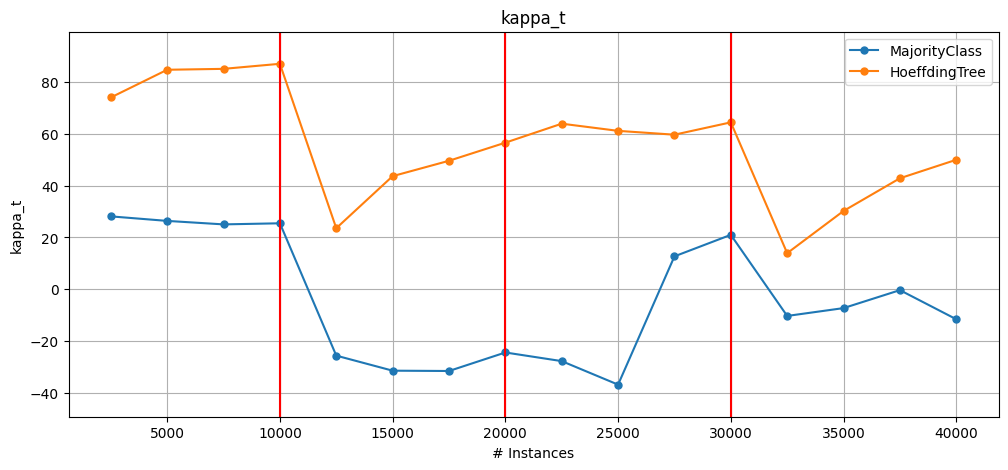

In [4]:
mc = MajorityClass(schema=streaming_dataset.get_schema())
ht = HoeffdingTree(schema=streaming_dataset.get_schema())

mc_results = prequential_evaluation(stream=streaming_dataset, learner=mc, window_size=window_size, max_instances=max_instances)
ht_results = prequential_evaluation(stream=streaming_dataset, learner=ht, window_size=window_size, max_instances=max_instances)
plot_windowed_results(mc_results, ht_results, metric="kappa_t")

## 1.2 Online Bagging

[OB5] accuracy: 82.8475 wallclock: 0.6763381958007812
[OB30] accuracy: 83.38 wallclock: 3.2068300247192383


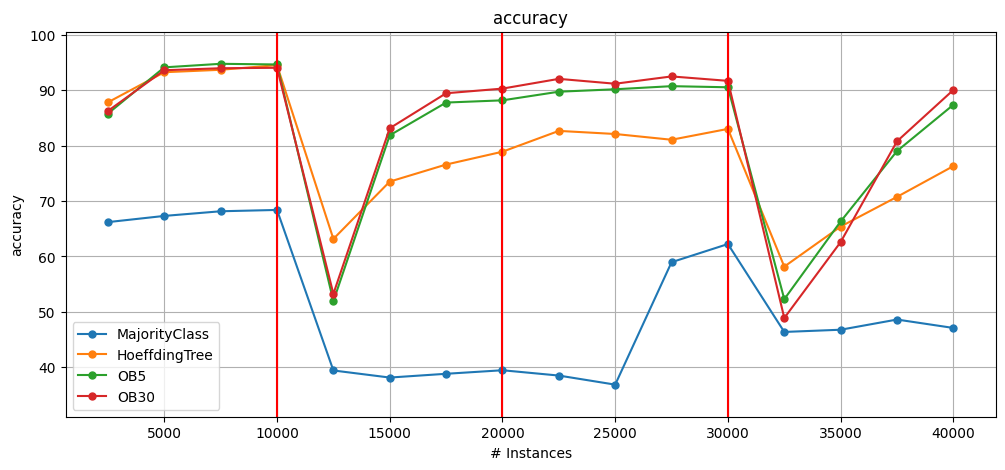

In [3]:
ob5 = OnlineBagging(schema=streaming_dataset.get_schema(), ensemble_size=5)
ob30 = OnlineBagging(schema=streaming_dataset.get_schema(), ensemble_size=30)

ob5_results = prequential_evaluation(stream=streaming_dataset, learner=ob5, window_size=window_size, max_instances=max_instances)
ob30_results = prequential_evaluation(stream=streaming_dataset, learner=ob30, window_size=window_size, max_instances=max_instances)

print(f"[OB5] accuracy: {ob5_results.cumulative.accuracy()} wallclock: {ob5_results.wallclock()}")
print(f"[OB30] accuracy: {ob30_results.cumulative.accuracy()} wallclock: {ob30_results.wallclock()}")

ob5_results.learner = "OB5"
ob30_results.learner = "OB30"
plot_windowed_results(mc_results, ht_results, ob5_results, ob30_results, metric='accuracy')

##  1.3 AdaptiveRandomForest

* ARF supports multi-threading (see `number_of_jobs` parameter)

[ARF5] accuracy: 73.0175  wallclock: 4.221542835235596
[ARF50] accuracy: 73.78 wallclock: 14.51630425453186


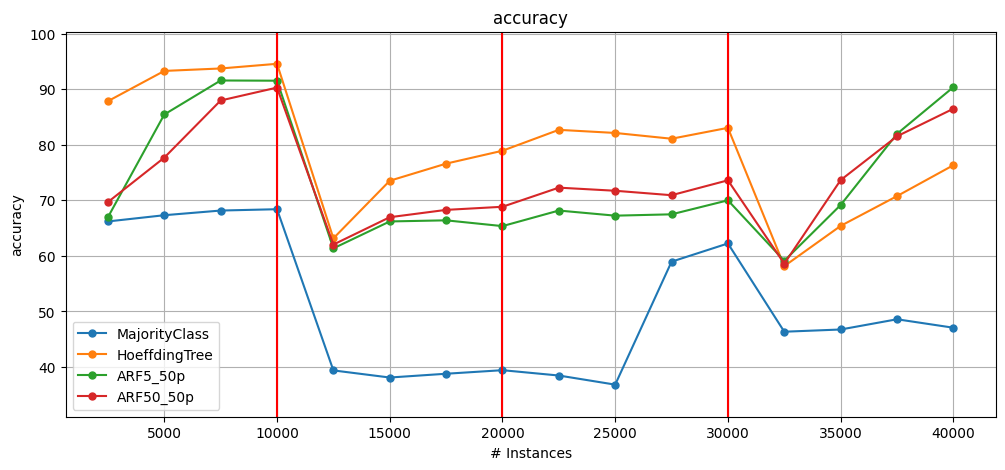

In [4]:
arf5_50p = AdaptiveRandomForestClassifier(schema=streaming_dataset.get_schema(), ensemble_size=5, max_features=0.5)
arf50_50p = AdaptiveRandomForestClassifier(schema=streaming_dataset.get_schema(), ensemble_size=50, max_features=0.5, number_of_jobs=4)

arf5_50p_results = prequential_evaluation(stream=streaming_dataset, learner=arf5_50p, window_size=window_size, max_instances=max_instances)
arf50_50p_results = prequential_evaluation(stream=streaming_dataset, learner=arf50_50p, window_size=window_size, max_instances=max_instances)

print(f"[ARF5] accuracy: {arf5_50p_results.cumulative.accuracy()}  wallclock: {arf5_50p_results.wallclock()}")
print(f"[ARF50] accuracy: {arf50_50p_results.cumulative.accuracy()} wallclock: {arf50_50p_results.wallclock()}")

arf5_50p_results.learner = "ARF5_50p"
arf50_50p_results.learner = "ARF50_50p"
# We keep adding more results to our output for comparison. 
plot_windowed_results(mc_results, ht_results, arf5_50p_results, arf50_50p_results, metric='accuracy')

## 1.4 Streaming Random Patches


[SRP5] accuracy: 69.66 wallclock: 2.949735164642334
[SRP50] accuracy: 80.34750000000001 wallclock: 68.51964163780212


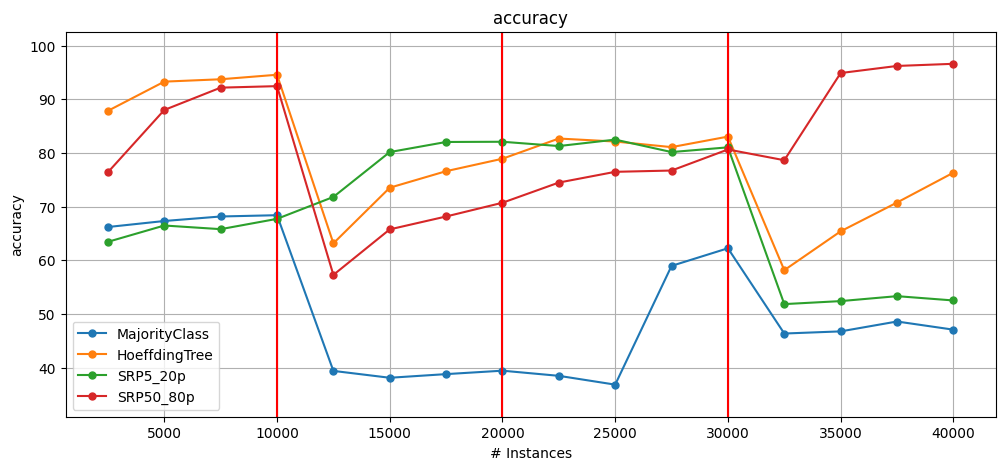

In [5]:
srp5_20p = StreamingRandomPatches(schema=streaming_dataset.get_schema(), ensemble_size=5, max_features=0.2)
srp50_80p = StreamingRandomPatches(schema=streaming_dataset.get_schema(), ensemble_size=50, max_features=0.8)

srp5_20p_results = prequential_evaluation(stream=streaming_dataset, learner=srp5_20p, window_size=window_size, max_instances=max_instances)
srp50_80p_results = prequential_evaluation(stream=streaming_dataset, learner=srp50_80p, window_size=window_size, max_instances=max_instances)

print(f"[SRP5] accuracy: {srp5_20p_results.cumulative.accuracy()} wallclock: {srp5_20p_results.wallclock()}")
print(f"[SRP50] accuracy: {srp50_80p_results.cumulative.accuracy()} wallclock: {srp50_80p_results.wallclock()}")

srp5_20p_results.learner = "SRP5_20p"
srp50_80p_results.learner = "SRP50_80p"
plot_windowed_results(mc_results, ht_results, srp5_20p_results, srp50_80p_results, metric='accuracy')

## 1.5 Streaming Gradient Boosted Trees


[SGBT] accuracy: 93.47999999999999 wallclock: 19.16837978363037


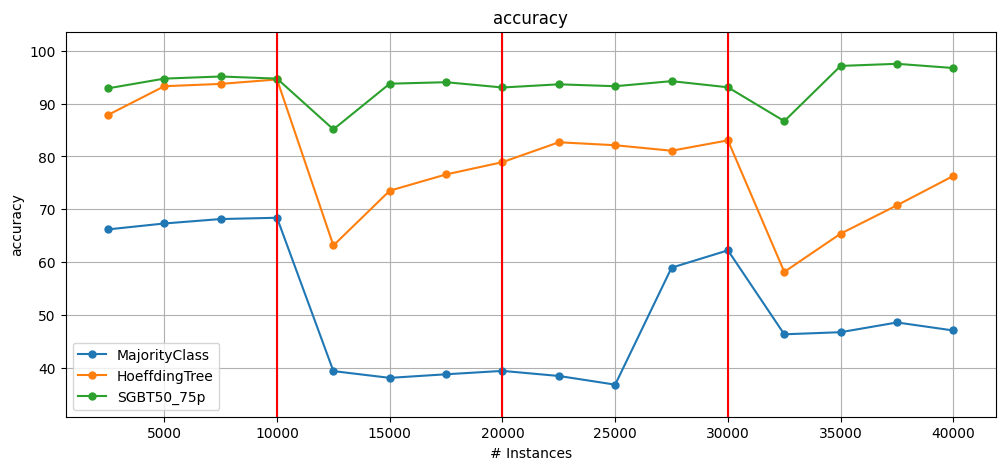

In [6]:
sgbt50_75p = StreamingGradientBoostedTrees(schema=streaming_dataset.get_schema(), boosting_iterations=50, percentage_of_features=75)

sgbt50_75p_results = prequential_evaluation(stream=streaming_dataset, learner=sgbt50_75p, window_size=window_size, max_instances=max_instances)

print(f"[SGBT] accuracy: {sgbt50_75p_results.cumulative.accuracy()} wallclock: {sgbt50_75p_results.wallclock()}")

sgbt50_75p_results.learner = "SGBT50_75p"
plot_windowed_results(mc_results, ht_results, sgbt50_75p_results, metric='accuracy')

## 1.6. Comparing all classifiers

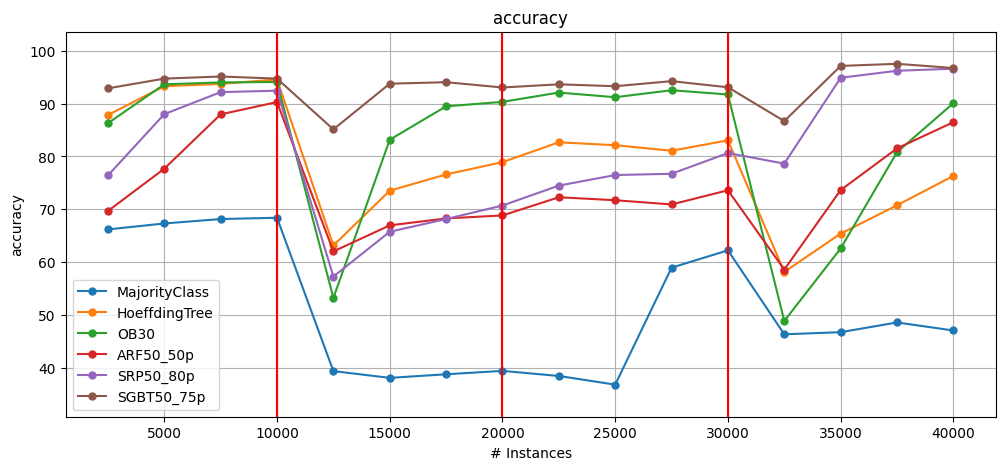

In [7]:
plot_windowed_results(mc_results, ht_results, ob30_results, arf50_50p_results, 
                      srp50_80p_results, sgbt50_75p_results, metric='accuracy')

# 2 Regression

* We introduce a simple example using regression just to show how similar it is to assess regressors using the **high-level evaluation functions**
* In the example below, we just use ```prequential_evaluation()``` but it would work with ```cumulative_evaluation()``` and ```windowed_evaluation()``` as well.
* One difference between Classification and Regression evaluation in CapyMOA is that the Evaluators are different. Instead of ```ClassificationEvaluator``` and ```ClassificationWindowedEvaluator``` functions use ```RegressionEvaluator``` and ```RegressionWindowedEvaluator```
## 2.1 Simple Regression Example

100% [............................................................................] 922613 / 922613kNNRegressor [cumulative] RMSE = 2.7229994765160916 and AdaptiveRandomForestRegressor  [cumulative] RMSE = 2.3894271579519426


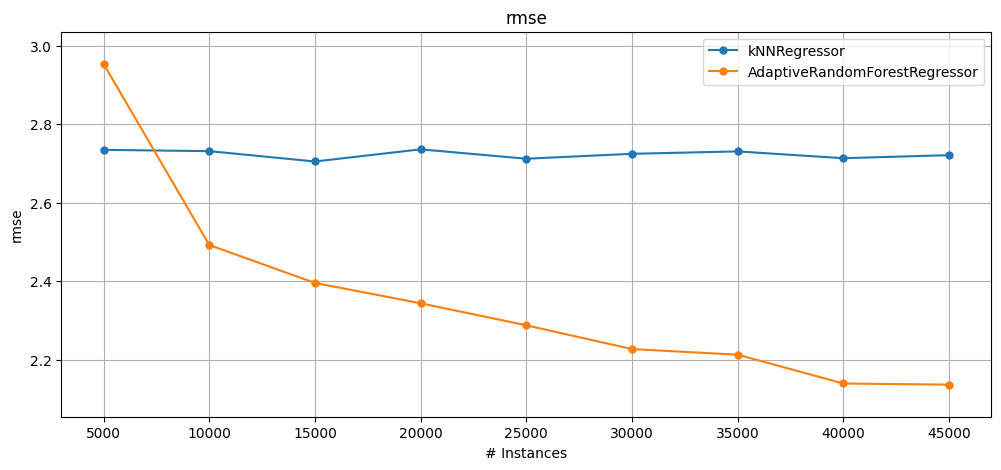

In [8]:
from capymoa.datasets import Fried
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.evaluation import prequential_evaluation
from capymoa.regressor import KNNRegressor, AdaptiveRandomForestRegressor, SOKNL

stream = Fried()
kNN_learner = KNNRegressor(schema=stream.get_schema(), k=5)
ARF_learner = AdaptiveRandomForestRegressor(schema=stream.get_schema(), ensemble_size=10)

kNN_results = prequential_evaluation(stream=stream, learner=kNN_learner, window_size=5000)
ARF_results = prequential_evaluation(stream=stream, learner=ARF_learner, window_size=5000)

print(f"{kNN_results['learner']} [cumulative] RMSE = {kNN_results['cumulative'].rmse()} and {ARF_results['learner']}  [cumulative] RMSE = {ARF_results['cumulative'].rmse()}")

plot_windowed_results(kNN_results, ARF_results, metric='rmse')

## 2.2 Evaluating a single stream using multiple learners (Regression)

* ```prequential_evaluation_multiple_learners``` also works for multiple regressors, the example below shows how it can be used.
* Notice that this high-level evaluation function does not measure the `wallclock` or `cpu_time` for the learners as the execution is interleaved

Cumulative results for each learner:
kNNReg_k5, RMSE: 2.72, adjusted R2: 0.70
kNNReg_k2, RMSE: 3.08, adjusted R2: 0.62
kNNReg_k5_median, RMSE: 2.94, adjusted R2: 0.65
ARFReg_s100, RMSE: 2.20, adjusted R2: 0.81
SOKNL_s100, RMSE: 2.05, adjusted R2: 0.83


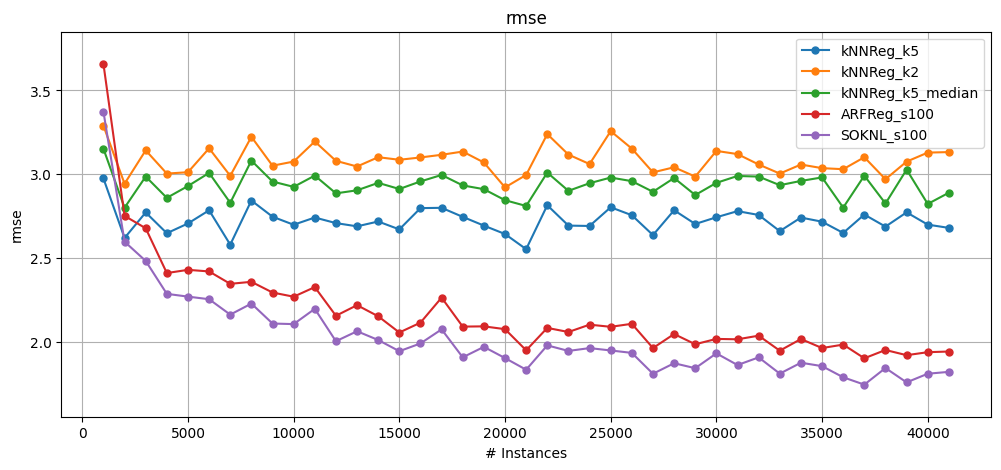

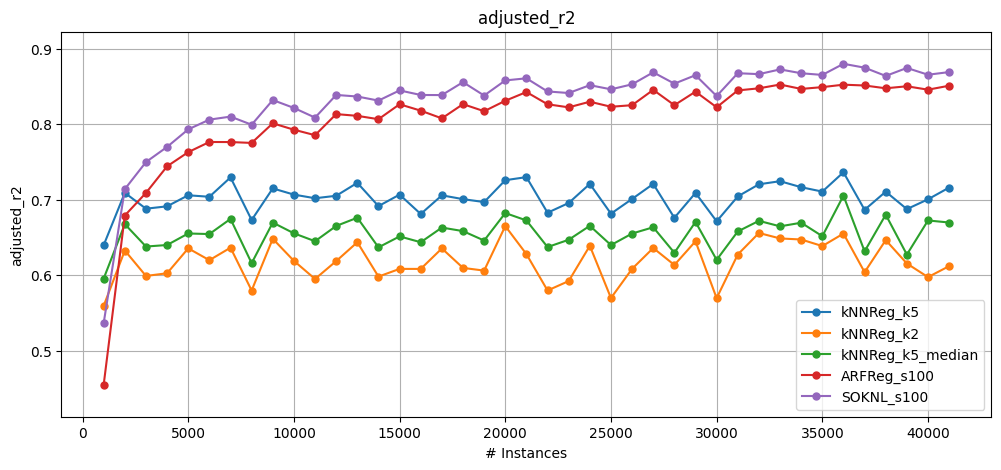

In [9]:
from capymoa.evaluation import prequential_evaluation_multiple_learners

# Define the learners + an alias (dictionary key)
learners = {
    'kNNReg_k5': KNNRegressor(schema=stream.get_schema(), k=5),
    'kNNReg_k2': KNNRegressor(schema=stream.get_schema(), k=2),
    'kNNReg_k5_median': KNNRegressor(schema=stream.get_schema(), CLI='-k 5 -m'),
    'ARFReg_s100': AdaptiveRandomForestRegressor(schema=stream.get_schema()),
    'SOKNL_s100': SOKNL(schema=stream.get_schema())
}

results = prequential_evaluation_multiple_learners(stream, learners)

print('Cumulative results for each learner:')
for learner_id in learners.keys():
    if learner_id in results:
        cumulative = results[learner_id]['cumulative']
        print(f"{learner_id}, RMSE: {cumulative.rmse():.2f}, adjusted R2: {cumulative.adjusted_r2():.2f}")
        results[learner_id].learner = learner_id

# Tip: invoking metrics_header() from an Evaluator will show us all the metrics available, 
plot_windowed_results(results['kNNReg_k5'], results['kNNReg_k2'], results['kNNReg_k5_median'], 
                      results['ARFReg_s100'], results['SOKNL_s100'], metric="rmse")

plot_windowed_results(results['kNNReg_k5'], results['kNNReg_k2'], results['kNNReg_k5_median'], 
                      results['ARFReg_s100'], results['SOKNL_s100'], metric="adjusted_r2")

## 2.3 Plotting predictions vs. ground truth over time (Regression)

* In Regression it is sometimes desirable to plot **predictions vs. ground truth** to observe what is happening with the Stream. If we create a custom loop and use the Evaluators directly it is trivial to store the ground truth and predictions, and then proceed to plot them. However, to make people's life easier ```plot_predictions_vs_ground_truth``` function can be used.

* For massive streams with millions of instances it can be unbearable to plot all at once, thus we can specify a ```plot_interval``` (that we want to investigate) to ```plot_predictions_vs_ground_truth```. By default, the plot function will attempt to plot everything, i.e. if ```plot_interval=None```, which is seldom a good idea. 

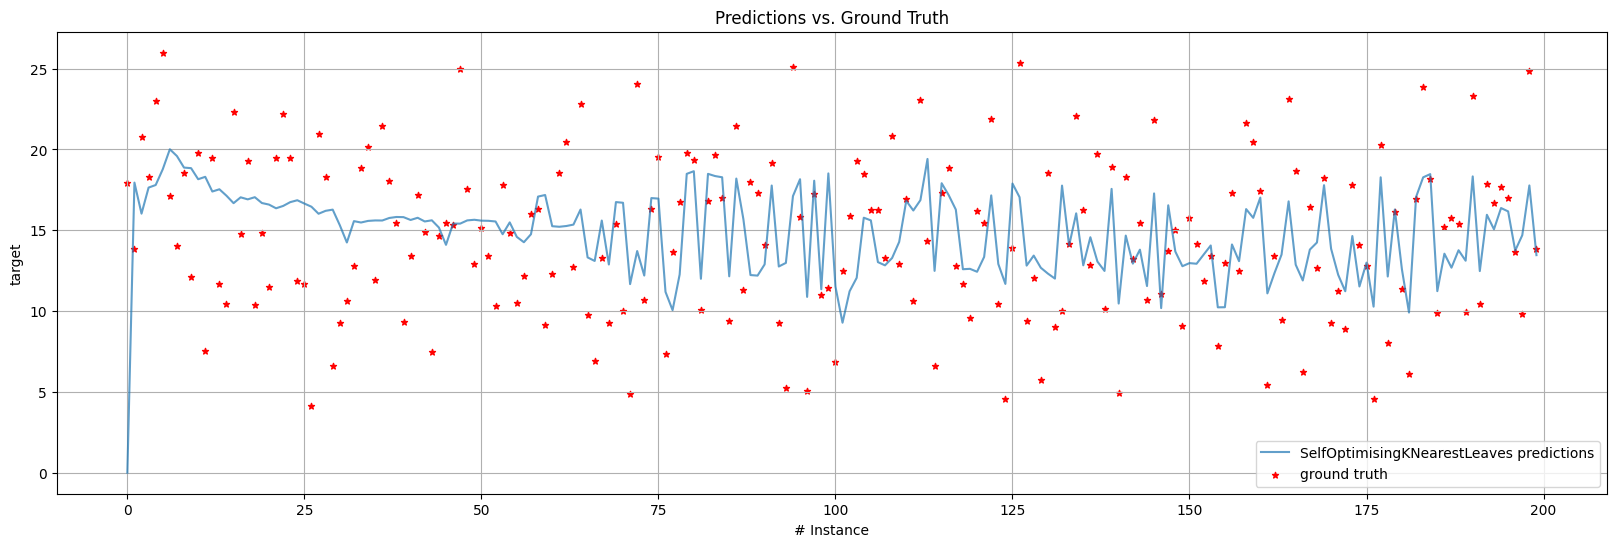

In [10]:
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_predictions_vs_ground_truth
from capymoa.regressor import KNNRegressor, AdaptiveRandomForestRegressor
from capymoa.datasets import Fried

stream = Fried()
SOKNL_learner = SOKNL(schema=stream.get_schema(), ensemble_size=100)

# When we specify store_predictions and store_y, the results will also include all the predictions and all the ground truth y. 
# It is useful for debugging and outputting the predictions elsewhere. 
# We don't need to store the ground-truth for every experiment, since it is always the same for the same stream
SOKNL_results = prequential_evaluation(stream=stream, learner=SOKNL_learner, window_size=5000, store_predictions=True, store_y=True)


# Plot only 200 predictions (see plot_interval)
plot_predictions_vs_ground_truth(SOKNL_results, ground_truth=kNN_results['ground_truth_y'], plot_interval=(0, 200))

## 3. Prediction intervals

In this part of the tutorial we show how to use prediction interval methods in CapyMOA (MVE and AdaPI), including evaluation and visualization. 

More details about prediction intervals for streaming data can be found in [Adaptive Prediction Interval for Data Stream Regression, PAKDD 2024](https://link.springer.com/chapter/10.1007/978-981-97-2259-4_10)

* An example of the use case of prediction interval in CapyMOA
* The prediction interval methods require a base regression model like SOKNL
* In this first example, we show the evaluation using a **test-then-train loop**, the following example uses `prequential_evaluation()` to avoid write loops over and over again ;)

In [11]:
from capymoa.datasets import Fried
from capymoa.regressor import SOKNL
from capymoa.prediction_interval import MVE, AdaPI
from capymoa.evaluation.evaluation import PredictionIntervalEvaluator, PredictionIntervalWindowedEvaluator

fried_stream = Fried()

# build prediction interval learner in regular manner
soknl = SOKNL(schema=fried_stream.get_schema(), ensemble_size=10)
mve = MVE(schema=fried_stream.get_schema(), base_learner=soknl)

# build prediction interval learner in in-line manner
mve_inline = MVE(schema=fried_stream.get_schema(), base_learner=SOKNL(schema=fried_stream.get_schema(), ensemble_size=10))

# build prediction interval (basic and windowed) evaluators
mve_evaluator = PredictionIntervalEvaluator(schema=fried_stream.get_schema())
mve_windowed_evaluator = PredictionIntervalWindowedEvaluator(schema=fried_stream.get_schema(), window_size=1000)

# run test-then-train/prequential tasks
while fried_stream.has_more_instances():
    instance = fried_stream.next_instance()
    prediction = mve.predict(instance)
    mve_evaluator.update(instance.y_value, prediction)
    mve_windowed_evaluator.update(instance.y_value, prediction)
    mve.train(instance)

# show results
print(f'MVE cumulative evaluation: \n coverage: {mve_evaluator.coverage()}, NMPIW: {mve_evaluator.nmpiw()}')

MVE cumulative evaluation: 
 coverage: 97.28, NMPIW: 30.66


### 3.1 Prediction intervals using `prequential_evaluation()`

* Pretty much like the previous example, but this one uses `prequential_evaluation()`
* Notice how it is the same `prequential_evaluation()` we used for Classification and Regression problems.
* We also plot results over time in this example

MVE coverage: 97.28, NMPIW: 30.66
AdaPI coverage: 96.15, NMPIW: 28.53


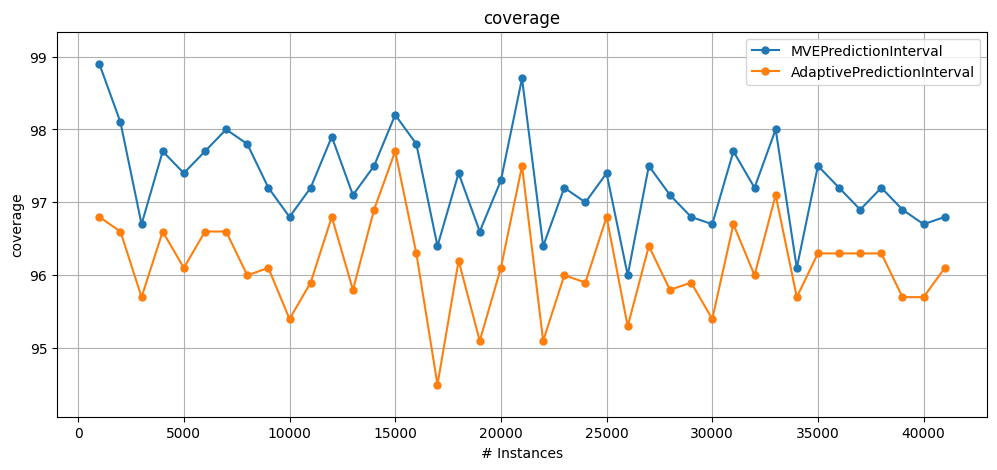

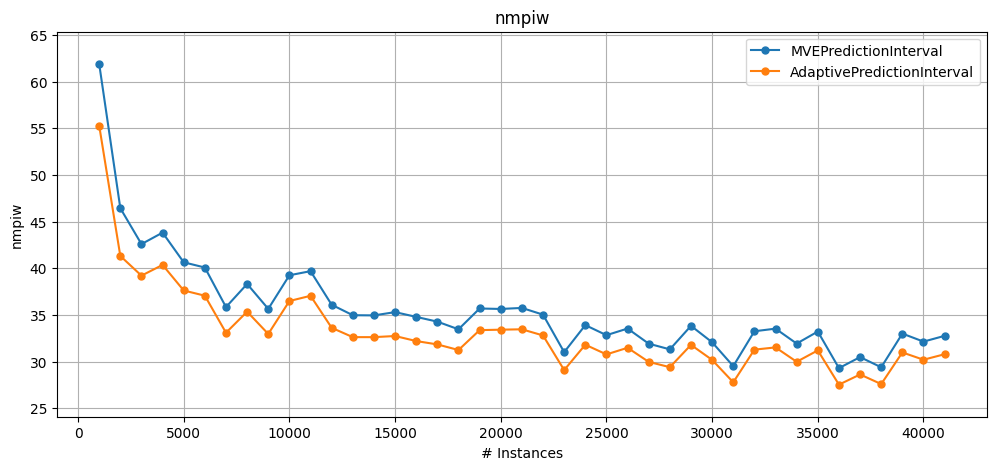

In [12]:
from capymoa.evaluation import prequential_evaluation
from capymoa.prediction_interval import AdaPI
from capymoa.evaluation.visualization import plot_windowed_results

# build prediction interval models
mve_learner = MVE(schema=fried_stream.get_schema(), 
                  base_learner=SOKNL(schema=fried_stream.get_schema(), ensemble_size=10))
adapi_learner = AdaPI(schema=fried_stream.get_schema(), 
                      base_learner=SOKNL(schema=fried_stream.get_schema(), ensemble_size=10), limit=0.001)
# gather results
mve_results = prequential_evaluation(stream=fried_stream, learner=mve_learner, window_size=1000)
adapi_results = prequential_evaluation(stream=fried_stream, learner=adapi_learner, window_size=1000)

# show overall results
print(f"MVE coverage: {mve_results.cumulative.coverage()}, NMPIW: {mve_results.cumulative.nmpiw()}")
print(f"AdaPI coverage: {adapi_results.cumulative.coverage()}, NMPIW: {adapi_results.cumulative.nmpiw()}")

# plot results over time
plot_windowed_results(mve_results,adapi_results, metric='coverage')
plot_windowed_results(mve_results,adapi_results, metric='nmpiw')

### 3.2 Plotting prediction intervals

* We also provide a visualization tool for plotting prediction intervals over time
* The function `plot_prediction_interval` can be used to plot the prediction intervals over time
* The function can take one or two prediction interval results as input

#### 3.2.1 Plotting for 1 algorithm
* To plot the prediction intervals over time, we need to store the predictions and the ground truth values (see `prequential_evaluation()`). This is not scalable for very large streams! But it is fine for analysis purposes.
* The shaded area represents the prediction interval, while the solid line represents the regressive predictions.
* The stared-markers represent the ground truth values that are covered by the intervals.
* The cross-markers represent the ground truth values that are outside the intervals. 
* The colors can be adjusted by the `colors` parameter in the function as a list.
* `start` and `end` parameters can be used to specify the range of the plot.
* The `ground truth` and `predictions` can be omitted by setting the `plot_truth` and `plot_predictions` parameters to `False`.
* In this version, we need to set `optimise` to `Flase` to avoid subscribing problems in `prequential_evaluation()`

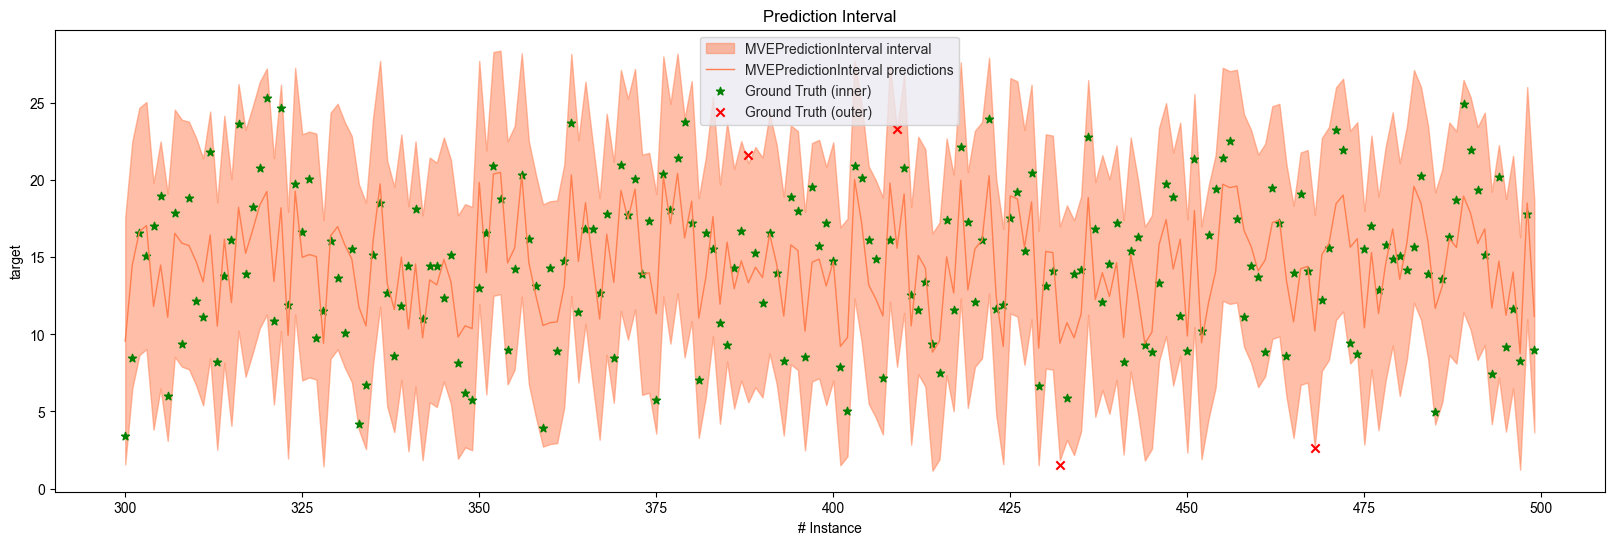

In [13]:
from capymoa.evaluation.visualization import plot_prediction_interval

new_mve_learner = MVE(schema=fried_stream.get_schema(), 
                      base_learner=SOKNL(schema=fried_stream.get_schema(), 
                                         ensemble_size=10)
                     )

new_mve_results = prequential_evaluation(stream=fried_stream, 
                                         learner=new_mve_learner, 
                                         window_size=1000, 
                                         optimise=False, 
                                         store_predictions=True, 
                                         store_y=True)

plot_prediction_interval(new_mve_results, start=300, end=500, colors=['coral'])

#### 3.2.2 Plotting for 2 algorithm

* For comparison purposes, we can also plot two prediction interval results over time.
* We don't take more results since it makes the plot too messy to read.

* \+ "plus" markers represent the ground truth values that are covered by the narrower but not by wider intervals. 
* The function automatically puts the wider area to the back to make the narrower intervals more visible.

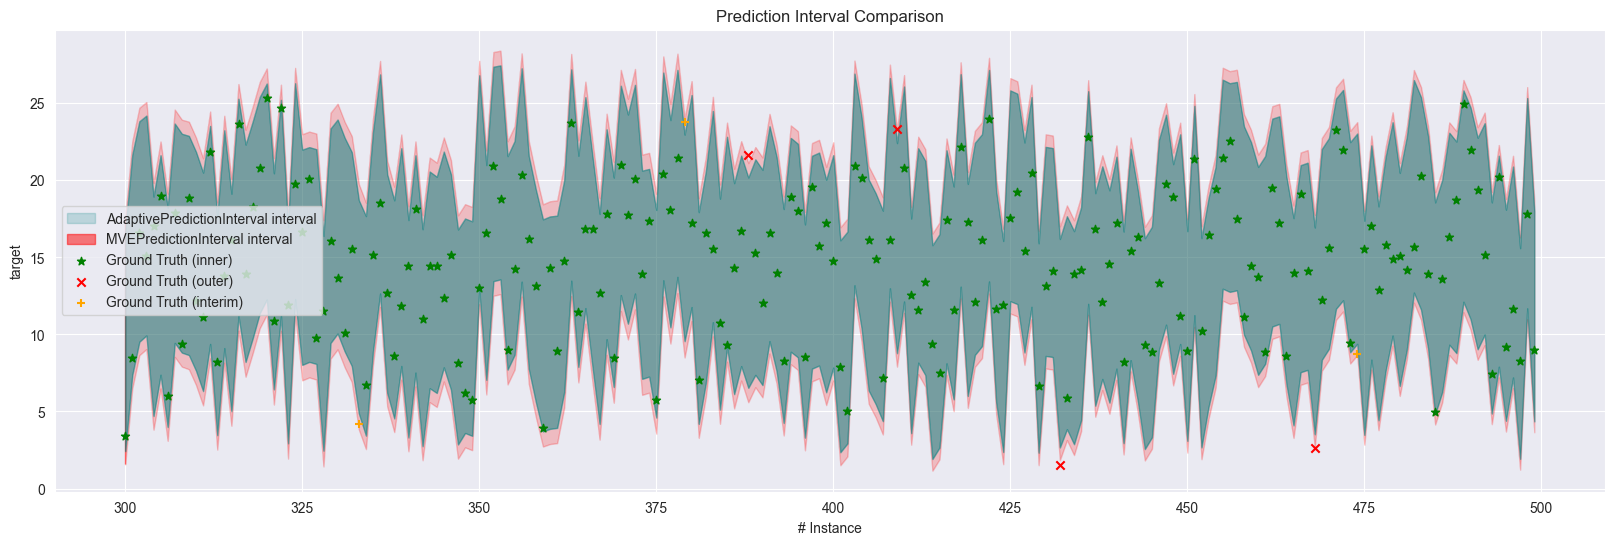

In [14]:
new_adapi_learner = AdaPI(schema=fried_stream.get_schema(), 
                          base_learner=SOKNL(schema=fried_stream.get_schema(), ensemble_size=10), limit=0.001)

new_adapi_results = prequential_evaluation(stream=fried_stream, 
                                           learner=new_adapi_learner, 
                                           window_size=1000,
                                           optimise=False,
                                           store_predictions=True, 
                                           store_y=True)

plot_prediction_interval(new_mve_results, new_adapi_results, start=300, end=500,colors=['red','teal'], plot_predictions=False)